# Nhận diện thiết bị IoT & Phát hiện bất thường bằng Federated Learning

## Nội dung chính
1. Import thư viện & tải dữ liệu
2. Tiền xử lý dữ liệu & chọn đặc trưng
3. Phân chia dữ liệu cho Federated Learning (IID, Non-IID, Quantity Skewed)
4. Huấn luyện mô hình nền tảng (BiLSTM)
5. Chuẩn bị client federated
6. Cài đặt Federated Learning (FedAvg)
7. Vòng lặp huấn luyện liên kết
8. Đánh giá mô hình toàn cục
9. Phân tích & trực quan hóa kết quả

In [2]:
# 1. Import thư viện & tải dữ liệu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
df = pd.read_csv('IoTDIAD.csv')
print('Shape:', df.shape)
df.head()

Shape: (33618, 84)


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,192.168.137.66-192.168.137.174-41082-80-6,192.168.137.66,41082.0,192.168.137.174,80.0,6.0,09/08/2022 11:27:38 AM,1527173.0,16.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS
1,192.168.137.66-192.168.137.254-55598-34287-6,192.168.137.66,55598.0,192.168.137.254,34287.0,6.0,09/08/2022 11:56:16 AM,9912071.0,7.0,2.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS
2,192.168.137.174-192.168.137.66-80-47994-6,192.168.137.174,80.0,192.168.137.66,47994.0,6.0,09/08/2022 11:29:10 AM,0.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS
3,192.168.137.66-192.168.137.254-59336-8009-6,192.168.137.66,59336.0,192.168.137.254,8009.0,6.0,09/08/2022 11:50:16 AM,349868.0,1.0,1.0,...,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS
4,192.168.137.66-192.168.137.254-55662-8009-6,192.168.137.66,55662.0,192.168.137.254,8009.0,6.0,09/08/2022 11:49:16 AM,215841.0,1.0,1.0,...,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS


Missing values: 0
Label distribution:


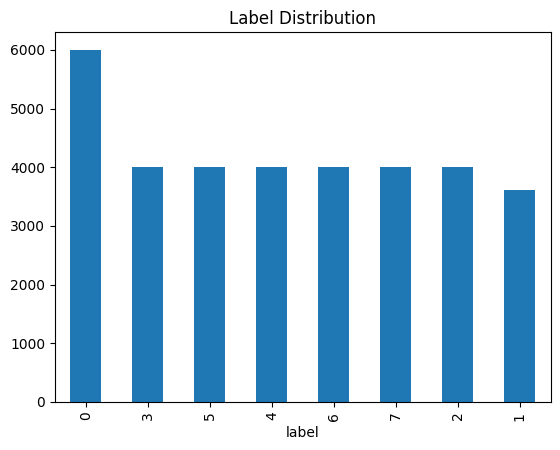

In [3]:
# 2. Tiền xử lý dữ liệu & chọn đặc trưng
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Second'] = df['Timestamp'].dt.second
df.drop(columns=['Timestamp'], inplace=True)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df['Flow ID'] = df['Flow ID'].astype('category').cat.codes
df['Src IP'] = df['Src IP'].astype('category').cat.codes
df['Dst IP'] = df['Dst IP'].astype('category').cat.codes
df = df.fillna(0)
print('Missing values:', df.isnull().sum().sum())
print('Label distribution:')
df['label'].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.show()

In [4]:
# Chuyển đổi device sang GPU (CUDA) nếu khả dụng
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Đang sử dụng GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('Không tìm thấy GPU, sử dụng CPU')

Đang sử dụng GPU: NVIDIA GeForce RTX 4050 Laptop GPU


In [5]:
import torch

# Tính weight cho toàn bộ tập dữ liệu
label_counts = df['label'].value_counts().sort_index()
class_weights = 1.0 / label_counts.values
class_weights = class_weights / class_weights.sum() * len(class_weights)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Khi khởi tạo loss function:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


=== IID Partition ===
client_0: 8404 samples
  Labels: {0: np.int64(1490), 2: np.int64(1052), 6: np.int64(1023), 4: np.int64(1017), 5: np.int64(1015), 7: np.int64(1007), 3: np.int64(975), 1: np.int64(825)}
client_1: 8404 samples
  Labels: {0: np.int64(1520), 3: np.int64(1038), 5: np.int64(1002), 6: np.int64(1000), 2: np.int64(975), 4: np.int64(973), 7: np.int64(950), 1: np.int64(946)}
client_2: 8404 samples
  Labels: {0: np.int64(1456), 7: np.int64(1038), 4: np.int64(1018), 5: np.int64(1008), 6: np.int64(998), 3: np.int64(978), 2: np.int64(970), 1: np.int64(938)}
client_3: 8406 samples
  Labels: {0: np.int64(1534), 3: np.int64(1009), 7: np.int64(1005), 2: np.int64(1003), 4: np.int64(992), 6: np.int64(979), 5: np.int64(975), 1: np.int64(909)}

Tổng số mẫu: 33618


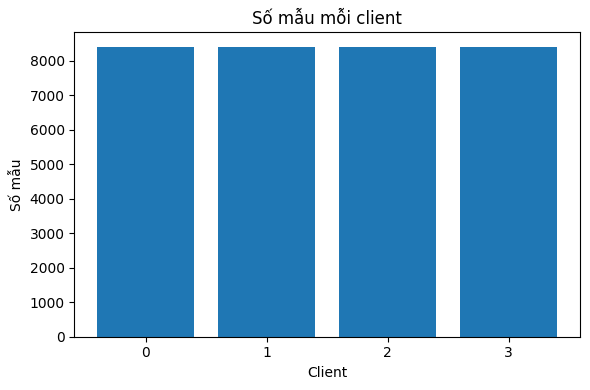


=== Non-IID by Label ===
client_0_label_0: 6000 samples
  Labels: {0: np.int64(6000)}
client_1_label_1: 3618 samples
  Labels: {1: np.int64(3618)}
client_2_label_2: 4000 samples
  Labels: {2: np.int64(4000)}
client_3_label_3: 4000 samples
  Labels: {3: np.int64(4000)}
client_4_label_4: 4000 samples
  Labels: {4: np.int64(4000)}
client_5_label_5: 4000 samples
  Labels: {5: np.int64(4000)}
client_6_label_6: 4000 samples
  Labels: {6: np.int64(4000)}
client_7_label_7: 4000 samples
  Labels: {7: np.int64(4000)}

Tổng số mẫu: 33618


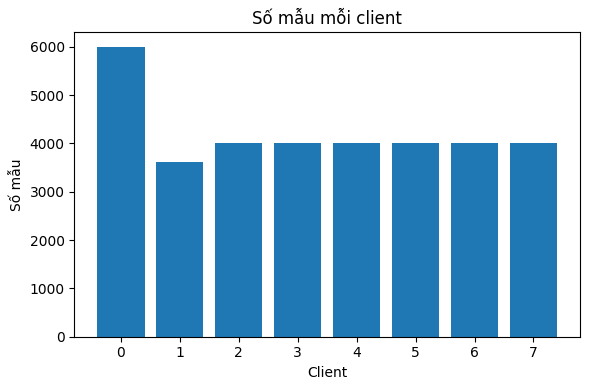


=== Quantity Skewed Partition ===
client_0: 898 samples
  Labels: {0: np.int64(168), 3: np.int64(109), 7: np.int64(109), 6: np.int64(108), 5: np.int64(105), 4: np.int64(100), 1: np.int64(100), 2: np.int64(99)}
client_1: 20044 samples
  Labels: {0: np.int64(3542), 4: np.int64(2410), 5: np.int64(2409), 2: np.int64(2408), 6: np.int64(2396), 7: np.int64(2384), 3: np.int64(2358), 1: np.int64(2137)}
client_2: 8385 samples
  Labels: {0: np.int64(1508), 3: np.int64(1019), 6: np.int64(1011), 7: np.int64(996), 4: np.int64(991), 5: np.int64(987), 2: np.int64(969), 1: np.int64(904)}
client_3: 4291 samples
  Labels: {0: np.int64(782), 2: np.int64(524), 3: np.int64(514), 7: np.int64(511), 4: np.int64(499), 5: np.int64(499), 6: np.int64(485), 1: np.int64(477)}

Tổng số mẫu: 33618

client_0: 898 samples
  Labels: {0: np.int64(168), 3: np.int64(109), 7: np.int64(109), 6: np.int64(108), 5: np.int64(105), 4: np.int64(100), 1: np.int64(100), 2: np.int64(99)}
client_1: 20044 samples
  Labels: {0: np.int64

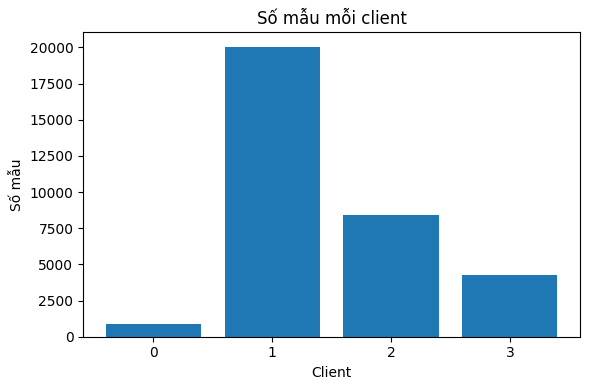

In [6]:
# 3. Phân chia dữ liệu cho Federated Learning
import random
from collections import defaultdict
import matplotlib.ticker as ticker
def create_iid_partition(df, num_clients, random_seed=42):
    np.random.seed(random_seed)
    df_shuffled = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    samples_per_client = len(df_shuffled) // num_clients
    iid_clients = {}
    for i in range(num_clients):
        start_idx = i * samples_per_client
        end_idx = len(df_shuffled) if i == num_clients - 1 else (i + 1) * samples_per_client
        iid_clients[f'client_{i}'] = df_shuffled.iloc[start_idx:end_idx].reset_index(drop=True)
    return iid_clients
def create_non_iid_partition_by_label(df, labels_per_client=1, random_seed=42):
    np.random.seed(random_seed)
    unique_labels = sorted(df['label'].unique())
    non_iid_clients = {}
    if labels_per_client == 1:
        for i, label in enumerate(unique_labels):
            client_data = df[df['label'] == label].reset_index(drop=True)
            non_iid_clients[f'client_{i}_label_{label}'] = client_data
    else:
        random.shuffle(unique_labels)
        num_clients = len(unique_labels) // labels_per_client
        for i in range(num_clients):
            client_labels = unique_labels[i*labels_per_client:(i+1)*labels_per_client]
            client_data = df[df['label'].isin(client_labels)].reset_index(drop=True)
            non_iid_clients[f'client_{i}_labels_{client_labels}'] = client_data
    return non_iid_clients
def create_quantity_skewed_partition(df, num_clients, skew_factor=0.1, random_seed=42):
    np.random.seed(random_seed)
    proportions = np.random.power(skew_factor, num_clients)
    proportions = proportions / proportions.sum()
    df_shuffled = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    quantity_skewed_clients = {}
    start_idx = 0
    for i in range(num_clients):
        num_samples = int(len(df_shuffled) * proportions[i])
        end_idx = min(start_idx + num_samples, len(df_shuffled))
        if i == num_clients - 1:
            end_idx = len(df_shuffled)
        quantity_skewed_clients[f'client_{i}'] = df_shuffled.iloc[start_idx:end_idx].reset_index(drop=True)
        start_idx = end_idx
    return quantity_skewed_clients
def analyze_partition(client_dict, title="Phân tích phân chia dữ liệu"):
    print(f"\n=== {title} ===")
    total_samples = 0
    label_distribution = defaultdict(int)
    for client_id, client_df in client_dict.items():
        num_samples = len(client_df)
        total_samples += num_samples
        client_labels = client_df['label'].value_counts()
        print(f"{client_id}: {num_samples} samples")
        print(f"  Labels: {dict(client_labels)}")
        for label, count in client_labels.items():
            label_distribution[label] += count
    print(f"\nTổng số mẫu: {total_samples}")
    # Vẽ biểu đồ số mẫu mỗi client, trục x chỉ hiển thị số nguyên
    plt.figure(figsize=(6, 4))
    client_sizes = [len(df) for df in client_dict.values()]
    ax = plt.gca()
    plt.bar(range(len(client_sizes)), client_sizes)
    plt.title('Số mẫu mỗi client')
    plt.xlabel('Client')
    plt.ylabel('Số mẫu')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()
# Tạo các phân chia dữ liệu
iid_clients = create_iid_partition(df, num_clients=4)
analyze_partition(iid_clients, "IID Partition")
non_iid_clients = create_non_iid_partition_by_label(df, labels_per_client=1)
analyze_partition(non_iid_clients, "Non-IID by Label")
quantity_skewed_clients = create_quantity_skewed_partition(df, num_clients=4, skew_factor=0.3)
analyze_partition(quantity_skewed_clients, "Quantity Skewed Partition")


=== Quantity Skewed Partition ===
client_0: 1344 samples
  Labels: {2: np.int64(168), 6: np.int64(168), 0: np.int64(168), 5: np.int64(168), 3: np.int64(168), 7: np.int64(168), 4: np.int64(168), 1: np.int64(168)}
client_1: 28336 samples
  Labels: {1: np.int64(3542), 5: np.int64(3542), 2: np.int64(3542), 0: np.int64(3542), 7: np.int64(3542), 4: np.int64(3542), 3: np.int64(3542), 6: np.int64(3542)}
client_2: 12064 samples
  Labels: {1: np.int64(1508), 3: np.int64(1508), 2: np.int64(1508), 0: np.int64(1508), 4: np.int64(1508), 7: np.int64(1508), 6: np.int64(1508), 5: np.int64(1508)}
client_3: 6256 samples
  Labels: {2: np.int64(782), 7: np.int64(782), 6: np.int64(782), 1: np.int64(782), 0: np.int64(782), 4: np.int64(782), 5: np.int64(782), 3: np.int64(782)}

Tổng số mẫu: 48000


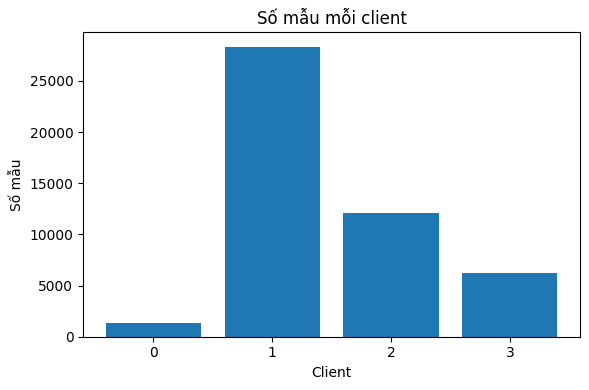

In [7]:
from sklearn.utils import resample

def oversample_client_df(client_df):
    max_count = client_df['label'].value_counts().max()
    dfs = []
    for label in client_df['label'].unique():
        df_label = client_df[client_df['label'] == label]
        df_label_upsampled = resample(df_label, replace=True, n_samples=max_count, random_state=42)
        dfs.append(df_label_upsampled)
    return pd.concat(dfs).reset_index(drop=True)

# Áp dụng cho từng client trong quantity_skewed_clients
for client_id in quantity_skewed_clients:
    quantity_skewed_clients[client_id] = oversample_client_df(quantity_skewed_clients[client_id])
analyze_partition(quantity_skewed_clients, "Quantity Skewed Partition")

Epoch 1/2000 | Train Acc: 12.57% | Test Acc: 74.38% | Loss: 1.3843
Epoch 2/2000 | Train Acc: 73.89% | Test Acc: 77.95% | Loss: 1.2603
Epoch 3/2000 | Train Acc: 77.70% | Test Acc: 79.28% | Loss: 1.1528
Epoch 4/2000 | Train Acc: 79.42% | Test Acc: 80.36% | Loss: 1.0552
Epoch 5/2000 | Train Acc: 80.14% | Test Acc: 80.99% | Loss: 0.9633
Epoch 6/2000 | Train Acc: 80.84% | Test Acc: 81.61% | Loss: 0.8758
Epoch 4/2000 | Train Acc: 79.42% | Test Acc: 80.36% | Loss: 1.0552
Epoch 5/2000 | Train Acc: 80.14% | Test Acc: 80.99% | Loss: 0.9633
Epoch 6/2000 | Train Acc: 80.84% | Test Acc: 81.61% | Loss: 0.8758
Epoch 7/2000 | Train Acc: 81.48% | Test Acc: 82.38% | Loss: 0.7932
Epoch 8/2000 | Train Acc: 82.13% | Test Acc: 82.95% | Loss: 0.7164
Epoch 9/2000 | Train Acc: 82.83% | Test Acc: 83.31% | Loss: 0.6467
Epoch 7/2000 | Train Acc: 81.48% | Test Acc: 82.38% | Loss: 0.7932
Epoch 8/2000 | Train Acc: 82.13% | Test Acc: 82.95% | Loss: 0.7164
Epoch 9/2000 | Train Acc: 82.83% | Test Acc: 83.31% | Loss: 0.

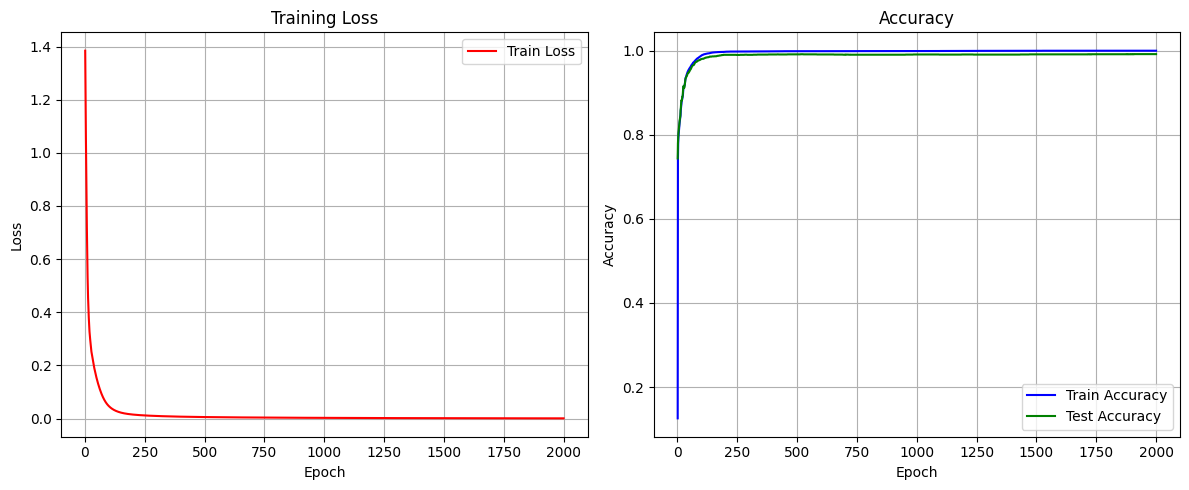

In [8]:
# 4. Huấn luyện mô hình nền tảng (BiLSTM)
foundation_labels = sorted(df['label'].unique())[:4]
df_foundation = df[df['label'].isin(foundation_labels)].reset_index(drop=True)
X_found = df_foundation.drop(columns=['label']).values
y_found = df_foundation['label'].values
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_found, y_found, test_size=0.2, stratify=y_found, random_state=42)
# Xử lý NaN, infinity, giá trị quá lớn/tràn
X_train_f = np.nan_to_num(X_train_f, nan=0, posinf=0, neginf=0)
X_test_f = np.nan_to_num(X_test_f, nan=0, posinf=0, neginf=0)
X_train_f = np.clip(X_train_f, -1e10, 1e10)
X_test_f = np.clip(X_test_f, -1e10, 1e10)

scaler_f = StandardScaler()
X_train_f_scaled = scaler_f.fit_transform(X_train_f)
X_test_f_scaled = scaler_f.transform(X_test_f)
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out
input_size = X_train_f_scaled.shape[1]
hidden_size = 128
num_classes = len(np.unique(y_train_f))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTM(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 2000
train_accuracies = []
test_accuracies = []
train_losses = []
X_train_tensor = torch.tensor(X_train_f_scaled, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test_f_scaled, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train_f, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test_f, dtype=torch.long).to(device)
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    _, predicted_train = torch.max(outputs, 1)
    train_acc = (predicted_train == y_train_tensor).float().mean().item()
    train_accuracies.append(train_acc)
    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_tensor)
        _, predicted_test = torch.max(outputs_test, 1)
        test_acc = (predicted_test == y_test_tensor).float().mean().item()
        test_accuracies.append(test_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}% | Loss: {loss.item():.4f}")
print("\nClassification Report (Foundation Model):")
print(classification_report(y_test_tensor.cpu().numpy(), predicted_test.cpu().numpy(), zero_division=0))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy', color='green')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# 5. Chuẩn bị client federated
federated_labels = sorted(df['label'].unique())[4:]
client_data = {}
selected_columns = list(range(input_size))  # Sử dụng toàn bộ đặc trưng đã chọn từ foundation
for label in federated_labels:
    df_client = df[df['label'] == label].reset_index(drop=True)
    X_client = df_client.drop(columns=['label']).values
    y_client = df_client['label'].values
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_client, y_client, test_size=0.2, random_state=42)
    # Xử lý NaN, infinity, giá trị quá lớn/tràn cho từng client
    X_train_c = np.nan_to_num(X_train_c, nan=0, posinf=0, neginf=0)
    X_test_c = np.nan_to_num(X_test_c, nan=0, posinf=0, neginf=0)
    X_train_c = np.clip(X_train_c, -1e10, 1e10)
    X_test_c = np.clip(X_test_c, -1e10, 1e10)
    
    scaler_c = StandardScaler()
    X_train_c_scaled = scaler_c.fit_transform(X_train_c)
    X_test_c_scaled = scaler_c.transform(X_test_c)
    X_train_c_selected = X_train_c_scaled[:, selected_columns]
    X_test_c_selected = X_test_c_scaled[:, selected_columns]
    client_data[label] = {
        'X_train': X_train_c_selected,
        'y_train': y_train_c,
        'X_test': X_test_c_selected,
        'y_test': y_test_c,
        'scaler': scaler_c
    }
    print(f"Client label {label}: Train shape = {X_train_c_selected.shape}, Test shape = {X_test_c_selected.shape}")
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Client label 4: Train shape = (3200, 88), Test shape = (800, 88)
Client label 5: Train shape = (3200, 88), Test shape = (800, 88)
Client label 6: Train shape = (3200, 88), Test shape = (800, 88)
Client label 7: Train shape = (3200, 88), Test shape = (800, 88)


In [13]:
# 6. Cài đặt Federated Learning (FedAvg)
import copy
class FederatedClient:
    def __init__(self, client_id, client_data, model_class, model_params):
        self.client_id = client_id
        self.raw_data = client_data
        self.model_class = model_class
        self.model_params = model_params
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.prepare_local_data()
    def prepare_local_data(self):
        X = self.raw_data.drop(columns=['label']).values
        y = self.raw_data['label'].values
        X = np.nan_to_num(X, nan=0, posinf=0, neginf=0)
        X = np.clip(X, -1e10, 1e10)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        self.X_train_tensor = torch.tensor(self.X_train_scaled, dtype=torch.float32).to(self.device)
        self.X_test_tensor = torch.tensor(self.X_test_scaled, dtype=torch.float32).to(self.device)
        self.y_train_tensor = torch.tensor(self.y_train, dtype=torch.long).to(self.device)
        self.y_test_tensor = torch.tensor(self.y_test, dtype=torch.long).to(self.device)
    def local_train(self, global_weights, local_epochs=5, lr=0.001):
        local_model = self.model_class(**self.model_params).to(self.device)
        local_model.load_state_dict(global_weights)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(local_model.parameters(), lr=lr)
        for epoch in range(local_epochs):
            optimizer.zero_grad()
            outputs = local_model(self.X_train_tensor.unsqueeze(1))
            loss = criterion(outputs, self.y_train_tensor)
            if torch.isfinite(loss):
                loss.backward()
                torch.nn.utils.clip_grad_norm_(local_model.parameters(), max_norm=1.0)
                optimizer.step()
        updated_weights = {k: v.cpu().clone() for k, v in local_model.state_dict().items()}
        return updated_weights
class FederatedServer:
    def __init__(self, model_class, model_params):
        self.model_class = model_class
        self.model_params = model_params
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.global_model = model_class(**model_params).to(self.device)
        self.global_weights = {k: v.cpu().clone() for k, v in self.global_model.state_dict().items()}
    def aggregate_weights(self, client_weights_list, client_sample_sizes=None):
        if not client_weights_list:
            return self.global_weights
        if client_sample_sizes is None:
            # Mặc định: trung bình đều
            aggregated_weights = copy.deepcopy(client_weights_list[0])
            for key in aggregated_weights.keys():
                for i in range(1, len(client_weights_list)):
                    aggregated_weights[key] += client_weights_list[i][key]
                aggregated_weights[key] = aggregated_weights[key] / len(client_weights_list)
            return aggregated_weights
        # Weighted FedAvg
        total_samples = sum(client_sample_sizes)
        aggregated_weights = copy.deepcopy(client_weights_list[0])
        for key in aggregated_weights.keys():
            aggregated_weights[key] = client_weights_list[0][key] * (client_sample_sizes[0] / total_samples)
            for i in range(1, len(client_weights_list)):
                aggregated_weights[key] += client_weights_list[i][key] * (client_sample_sizes[i] / total_samples)
        return aggregated_weights

In [14]:
# 7. Vòng lặp huấn luyện liên kết
num_rounds = 400
local_epochs = 10
model_params = {'input_size': input_size, 'hidden_size': 64, 'num_classes': len(df['label'].unique())}

# *** SỬA ĐỔI QUAN TRỌNG: Sử dụng quantity_skewed_clients đã được oversample ***
clients = []
# Chọn bộ dữ liệu đã được cân bằng
client_dataset_to_use = quantity_skewed_clients 

for client_id, df_client in client_dataset_to_use.items():
    if len(df_client) > 0:
        clients.append(FederatedClient(client_id, df_client, BiLSTM, model_params))

server = FederatedServer(BiLSTM, model_params)
global_loss_history = []
global_acc_history = []
criterion_eval = nn.CrossEntropyLoss()

for rnd in range(num_rounds):
    print(f'\n--- FedAvg Round {rnd+1}/{num_rounds} ---')
    local_weights = []
    client_sample_sizes = [len(client.raw_data) for client in clients]
    for client in clients:
        updated_weights = client.local_train(server.global_weights, local_epochs=local_epochs)
        local_weights.append(updated_weights)
    server.global_weights = server.aggregate_weights(local_weights, client_sample_sizes=client_sample_sizes)
    
    # Đánh giá global model trên tất cả client test set
    accs = []
    losses = []
    total_samples = 0
    for client in clients:
        model = BiLSTM(**model_params).to(client.device)
        model.load_state_dict(server.global_weights)
        model.eval()
        with torch.no_grad():
            outputs = model(client.X_test_tensor.unsqueeze(1))
            loss = criterion_eval(outputs, client.y_test_tensor)
            _, predicted = torch.max(outputs, 1)
            acc = (predicted == client.y_test_tensor).float().mean().item()
            accs.append(acc * len(client.y_test_tensor))
            losses.append(loss.item() * len(client.y_test_tensor))
            total_samples += len(client.y_test_tensor)

    mean_acc = sum(accs) / total_samples
    mean_loss = sum(losses) / total_samples
    global_acc_history.append(mean_acc)
    global_loss_history.append(mean_loss)
    print(f'Round {rnd+1}: Mean Global Test Accuracy = {mean_acc:.4f} | Mean Global Test Loss = {mean_loss:.4f}')



--- FedAvg Round 1/400 ---
Round 1: Mean Global Test Accuracy = 0.5114 | Mean Global Test Loss = 1.9322

--- FedAvg Round 2/400 ---
Round 1: Mean Global Test Accuracy = 0.5114 | Mean Global Test Loss = 1.9322

--- FedAvg Round 2/400 ---
Round 2: Mean Global Test Accuracy = 0.5205 | Mean Global Test Loss = 1.7911

--- FedAvg Round 3/400 ---
Round 2: Mean Global Test Accuracy = 0.5205 | Mean Global Test Loss = 1.7911

--- FedAvg Round 3/400 ---
Round 3: Mean Global Test Accuracy = 0.5347 | Mean Global Test Loss = 1.6456

--- FedAvg Round 4/400 ---
Round 3: Mean Global Test Accuracy = 0.5347 | Mean Global Test Loss = 1.6456

--- FedAvg Round 4/400 ---
Round 4: Mean Global Test Accuracy = 0.5607 | Mean Global Test Loss = 1.4985

--- FedAvg Round 5/400 ---
Round 4: Mean Global Test Accuracy = 0.5607 | Mean Global Test Loss = 1.4985

--- FedAvg Round 5/400 ---
Round 5: Mean Global Test Accuracy = 0.5890 | Mean Global Test Loss = 1.3559

--- FedAvg Round 6/400 ---
Round 5: Mean Global Test A

In [15]:
# 8. Đánh giá mô hình toàn cục
all_preds = []
all_labels = []

final_model = BiLSTM(**model_params).to(device)
final_model.load_state_dict(server.global_weights)
final_model.eval()

for client in clients:
    with torch.no_grad():
        outputs = final_model(client.X_test_tensor.unsqueeze(1))
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(client.y_test_tensor.cpu().numpy())

# Lấy tên các lớp (class names) từ label_encoder
class_names = label_encoder.classes_

# Tính toán và in báo cáo chi tiết
print("--- Final Global Model Evaluation ---")
print("\nOverall Accuracy:", accuracy_score(all_labels, all_preds))
print("Overall F1-Score (Macro):", f1_score(all_labels, all_preds, average='macro', zero_division=0))
print("\nClassification Report (Per Class):")
# Lấy tên các lớp tương ứng với các nhãn có trong all_labels và all_preds
unique_labels_indices = sorted(list(set(all_labels) | set(all_preds)))
target_names = [class_names[i] for i in unique_labels_indices]
print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))


--- Final Global Model Evaluation ---

Overall Accuracy: 0.9587585919600083
Overall F1-Score (Macro): 0.9588324843115563

Classification Report (Per Class):
               precision    recall  f1-score   support

BenignTraffic       1.00      0.99      0.99      1177
  Brute_Force       0.81      0.90      0.85      1206
         DDoS       0.99      0.98      0.99      1220
          DoS       1.00      1.00      1.00      1273
        Mirai       1.00      1.00      1.00      1148
        Recon       1.00      1.00      1.00      1181
     Spoofing       0.89      0.80      0.84      1197
    Web-based       1.00      1.00      1.00      1200

     accuracy                           0.96      9602
    macro avg       0.96      0.96      0.96      9602
 weighted avg       0.96      0.96      0.96      9602



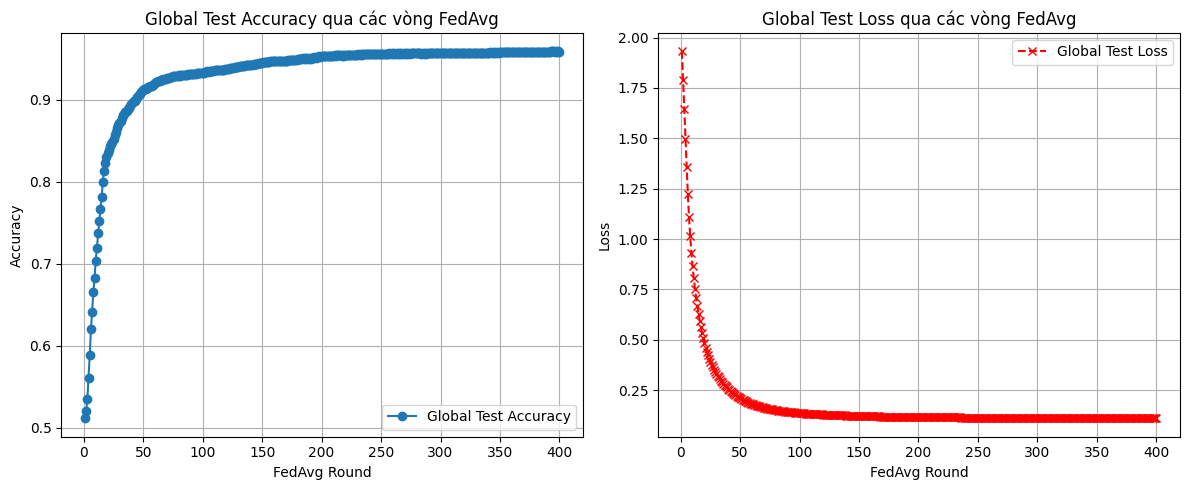

In [ ]:
# 9. Phân tích & trực quan hóa kết quả
plt.figure(figsize=(12, 5))

# Biểu đồ Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_rounds + 1), global_acc_history, marker='o', linestyle='-', label='Global Test Accuracy')
plt.title('Global Test Accuracy qua các vòng FedAvg')
plt.xlabel('FedAvg Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Biểu đồ Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_rounds + 1), global_loss_history, marker='x', linestyle='--', color='r', label='Global Test Loss')
plt.title('Global Test Loss qua các vòng FedAvg')
plt.xlabel('FedAvg Round')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
